Second modeling notebook: 

- Expand feature set used for modeling
- Implement PCA
- New model on top 30 PCA feature (model marginally improves, but only uses 3 PCA features)
- Cluster a bit on those 3 features, still figuring out what to maybe do with this.

In [18]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LinearRegression, ElasticNetCV
from sklearn.preprocessing import StandardScaler
from sklearn.cross_validation import cross_val_score


%matplotlib inline

In [2]:
df = pd.read_csv('./model_data.csv',index_col='Tm')

In [54]:
cols = [
 '4QC_passing_',
 'ANY/A_pass_def_',
 'ANY/A_passing_',
 'Att_pass_def_',
 'Att_passing_',
 'Att_rush_def_',
 'Att_rushing_',
 'Cmp_pass_def_',
 'Cmp_passing_',
 'DSRS_standings_',
 'FGA_scoring_',
 'FGA_scoring_def_',
 'FGM_scoring_',
 'FGM_scoring_def_',
 'Fmb_rushing_',
 'GWD_passing_',
 'Int_pass_def_',
 'Int_passing_',
 'NY/A_pass_def_',
 'NY/A_passing_',
 'OSRS_standings_',
 'PA_standings_',
 'PD_standings_',
 'Pts_scoring_',
 'Rate_pass_def_',
 'Rate_passing_',
 'SRS_standings_',
 'Sack_Yds_pass_def_',
 'Sack_Yds_passing_',
 'Sk_pass_def_',
 'Sk_passing_',
 'SoS_standings_',
 'TD_pass_def_',
 'TD_passing_',
 'TD_rush_def_',
 'TD_rushing_',
 'W_standings_',
 'Y/A_pass_def_',
 'Y/A_passing_',
 'Y/A_rush_def_',
 'Y/A_rushing_',
 'Y/C_pass_def_',
 'Y/C_passing_',
 'Yds_pass_def_',
 'Yds_passing_',
 'Yds_rush_def_',
 'Yds_rushing_']

In [64]:
len(cols)

47

In [55]:
cols_year = []
for i in cols:
    for col in df.columns:
        if i in col:
            cols_year.append(col)

In [56]:
df_new = df[cols_year]

In [63]:
df_new.shape

(32, 427)

In [65]:
df_new = df_new.transpose().drop_duplicates().transpose()

In [66]:
#build three tear looks 2010-2012

df_2010_2012 = df_new[[i for i in df_new.columns if ('2010' in i) | ('2011' in i)|('2012' in i)]]

df_2010_2012 = df_2010_2012.join(df_new['W_standings_2013'])

df_2010_2012.index = [i + ' (2010-2012)' for i in df_2010_2012.index]

df_2010_2012.columns = df_2010_2012.columns.map(lambda x: x.replace('2010','py_2').replace('2011','py_1').replace('2012','py').replace('2013','next'))

#build three tear looks 2011-2013
df_2011_2013 = df_new[[i for i in df_new.columns if ('2011' in i) | ('2012' in i)|('2013' in i)]]

df_2011_2013 = df_2011_2013.join(df_new['W_standings_2014'])

df_2011_2013.index = [i + ' (2011-2013)' for i in df_2011_2013.index]

df_2011_2013.columns = df_2011_2013.columns.map(lambda x: x.replace('2011','py_2').replace('2012','py_1').replace('2013','py').replace('2014','next'))

#build three year looks 2012-2014
df_2012_2014 = df_new[[i for i in df_new.columns if ('2012' in i) | ('2013' in i)|('2014' in i)]]

df_2012_2014 = df_2012_2014.join(df_new['W_standings_2015'])

df_2012_2014.index = [i + ' (2012-2014)' for i in df_2012_2014.index]

df_2012_2014.columns = df_2012_2014.columns.map(lambda x: x.replace('2012','py_2').replace('2013','py_1').replace('2014','py').replace('2015','next'))

#build three year looks 2013-2015

df_2013_2015 = df_new[[i for i in df_new.columns if ('2013' in i) | ('2014' in i)|('2015' in i)]]

df_2013_2015 = df_2013_2015.join(df_new['W_standings_2016'])

df_2013_2015.index = [i + ' (2013-2015)' for i in df_2013_2015.index]

df_2013_2015.columns = df_2013_2015.columns.map(lambda x: x.replace('2013','py_2').replace('2014','py_1').replace('2015','py').replace('2016','next'))

df_three_year = pd.concat([df_2010_2012,df_2011_2013,df_2012_2014])

print df_three_year.shape
df_three_year.head()

(96, 148)


,4QC_passing_py_2,4QC_passing_py_1,4QC_passing_py,ANY/A_pass_def_py_2,ANY/A_pass_def_py_1,ANY/A_pass_def_py,ANY/A_passing_py_2,ANY/A_passing_py_1,ANY/A_passing_py,Att_pass_def_py_2,...,Yds_passing_py_2,Yds_passing_py_1,Yds_passing_py,Yds_rush_def_py_2,Yds_rush_def_py_1,Yds_rush_def_py,Yds_rushing_py_2,Yds_rushing_py_1,Yds_rushing_py,W_standings_next
Jacksonville Jaguars (2010-2012),1.0,0.0,1.0,7.5,5.5,6.7,5.2,3.4,4.8,506.0,...,3065.0,2179.0,3419.0,1945.0,1667.0,2256.0,2395.0,1970.0,1369.0,4.0
Houston Texans (2010-2012),2.0,1.0,3.0,7.5,4.5,5.6,6.7,7.0,6.3,547.0,...,4144.0,3506.0,3830.0,1751.0,1536.0,1560.0,2042.0,2448.0,2123.0,2.0
Tampa Bay Buccaneers (2010-2012),5.0,1.0,1.0,5.2,7.5,7.0,6.9,4.7,6.3,521.0,...,3361.0,3650.0,3983.0,2107.0,2497.0,1320.0,2001.0,1458.0,1837.0,4.0
New York Jets (2010-2012),4.0,4.0,2.0,5.5,4.9,5.6,5.4,5.1,4.3,531.0,...,3242.0,3297.0,2891.0,1454.0,1777.0,2138.0,2374.0,1692.0,1896.0,8.0
New York Giants (2010-2012),1.0,7.0,3.0,5.4,5.9,6.4,6.1,7.4,6.6,539.0,...,3885.0,4734.0,3825.0,1620.0,1940.0,2066.0,2200.0,1427.0,1862.0,7.0


In [97]:
Xtrain = df_three_year.iloc[:,:-1]
ytrain = df_three_year['W_standings_next']
Xtest = df_2013_2015.iloc[:,:-1]
ytest = df_2013_2015['W_standings_next']

In [68]:
Xtrain.shape

(96, 147)

In [69]:
ss = StandardScaler()

In [98]:
Xstd = ss.fit_transform(Xtrain)
Xtest_std = ss.transform(Xtest)

In [71]:
enet = ElasticNetCV(l1_ratio=[.1, .5, .7, .9, .95, .99, 1],random_state=42)

In [72]:
enet.fit(Xstd,ytrain)

ElasticNetCV(alphas=None, copy_X=True, cv=None, eps=0.001, fit_intercept=True,
       l1_ratio=[0.1, 0.5, 0.7, 0.9, 0.95, 0.99, 1], max_iter=1000,
       n_alphas=100, n_jobs=1, normalize=False, positive=False,
       precompute='auto', random_state=42, selection='cyclic', tol=0.0001,
       verbose=0)

In [73]:
enet.alpha_

3.5553815546156629

In [74]:
enet.l1_ratio_

0.10000000000000001

In [75]:
enet.coef_

array([-0.        ,  0.04224822,  0.        , -0.01017118, -0.        ,
       -0.        ,  0.        ,  0.        ,  0.02081257,  0.        ,
       -0.        ,  0.        , -0.        ,  0.        ,  0.        ,
       -0.        , -0.        , -0.        ,  0.        ,  0.01608779,
        0.00701093, -0.        , -0.        , -0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.0226304 ,
       -0.        , -0.        ,  0.00277617,  0.        , -0.        ,
        0.        , -0.        , -0.        ,  0.00614631,  0.        ,
       -0.        , -0.        , -0.        ,  0.        ,  0.        ,
       -0.        ,  0.02580125,  0.        ,  0.        , -0.        ,
       -0.        , -0.        , -0.        , -0.00321722, -0.0119275 ,
       -0.        , -0.02972801,  0.        ,  0.        ,  0.01075271,
        0.        ,  0.03144116,  0.04043797, -0.        , -0.01994559,
       -0.04486585,  0.00875093,  0.04832762,  0.08737901,  0.  

In [76]:
scores = cross_val_score(enet,Xstd,ytrain,cv=3)

In [77]:
print scores.mean(), scores.std()

0.0485772875504 0.0599345859548


In [34]:
from sklearn.decomposition import PCA

In [78]:
pca = PCA()

In [102]:
pca_top_30 = pca.fit_transform(Xstd)[:,:30]
pca_test = pca.transform(Xtest_std)[:,:30]

In [85]:
pca.explained_variance_ratio_.cumsum()

array([ 0.1726538 ,  0.28625671,  0.36735916,  0.42875043,  0.4802561 ,
        0.5259727 ,  0.56542868,  0.59269093,  0.6180418 ,  0.64202549,
        0.66473959,  0.68544913,  0.70495891,  0.72380155,  0.74051086,
        0.75648621,  0.77138927,  0.78535072,  0.79894085,  0.81183974,
        0.82355569,  0.83509441,  0.84594928,  0.85620302,  0.86619457,
        0.87562234,  0.88416089,  0.89193133,  0.89938112,  0.90622906,
        0.91268657,  0.91898125,  0.92472212,  0.92984413,  0.93456115,
        0.93917473,  0.9433849 ,  0.94752434,  0.95137508,  0.95496635,
        0.95853457,  0.96168543,  0.96474521,  0.96748734,  0.9700605 ,
        0.97251999,  0.97475944,  0.97684206,  0.97874553,  0.98054827,
        0.98220955,  0.98362981,  0.98501576,  0.98626148,  0.98742942,
        0.98849367,  0.98946115,  0.99042001,  0.99127379,  0.99209206,
        0.99286559,  0.9935859 ,  0.99418217,  0.99474658,  0.99524789,
        0.99572647,  0.99614896,  0.99653674,  0.99692254,  0.99

In [80]:
pca.components_

array([[ 0.05869555,  0.0486046 ,  0.05869503, ...,  0.02222261,
         0.02183273,  0.03635104],
       [-0.0208485 ,  0.01611343,  0.03292784, ...,  0.03747071,
         0.09066251,  0.08327204],
       [-0.0058356 ,  0.0198135 ,  0.0594175 , ..., -0.09532162,
         0.04272951,  0.06948617],
       ..., 
       [ 0.03037622,  0.0148778 ,  0.08286974, ...,  0.01330087,
        -0.0373054 , -0.03066531],
       [-0.08004399, -0.03219613, -0.02244327, ..., -0.10128559,
         0.02041513, -0.04719302],
       [-0.00998518, -0.02850332,  0.0458582 , ..., -0.05314924,
        -0.02557196,  0.0568885 ]])

In [271]:
pca1_evec = pca.components_[0]

pd.DataFrame({'column':Xtrain.columns,'weight':pca1_evec}).sort_values('weight',ascending=False)


,column,weight
67,PD_standings_py_1,0.156006
76,Rate_passing_py_1,0.153691
79,SRS_standings_py_1,0.152690
118,AY/A_passing_py_1,0.152256
7,ANY/A_passing_py_1,0.151877
61,OSRS_standings_py_1,0.151773
70,Pts_scoring_py_1,0.149938
66,PD_standings_py_2,0.145314
78,SRS_standings_py_2,0.144750
109,W_standings_py_1,0.143706


In [272]:
enet.fit(pca_top_30,ytrain)

ElasticNetCV(alphas=None, copy_X=True, cv=None, eps=0.001, fit_intercept=True,
       l1_ratio=[0.1, 0.5, 0.7, 0.9, 0.95, 0.99, 1], max_iter=1000,
       n_alphas=100, n_jobs=1, normalize=False, positive=False,
       precompute='auto', random_state=42, selection='cyclic', tol=0.0001,
       verbose=0)

In [273]:
enet.alpha_

1.68994164515366

In [274]:
enet.l1_ratio_

0.5

In [275]:
enet.coef_

array([ 0.17976582,  0.08503968,  0.01184904,  0.        , -0.        ,
       -0.        ,  0.        , -0.        ,  0.        ,  0.        ,
       -0.        ,  0.        , -0.        ,  0.        , -0.        ,
        0.        , -0.        ,  0.        ,  0.        , -0.        ,
       -0.        , -0.        ,  0.        , -0.        ,  0.        ,
        0.        ,  0.        , -0.        ,  0.        ,  0.        ])

In [94]:
scores = cross_val_score(enet,pca_top_30,ytrain,cv=3)
print scores.mean(), scores.std()

0.0865991939312 0.0643387652471


In [276]:
enet.score(pca_test,ytest)

0.056125296608229736

In [105]:
ypred = enet.predict(pca_test)

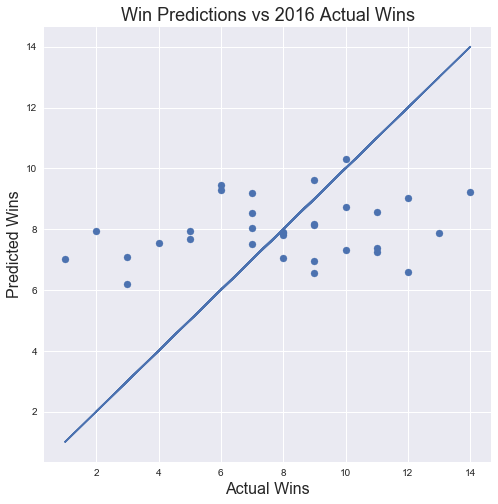

In [269]:
plt.figure(figsize=(8,8))
plt.scatter(ytest,ypred)
plt.plot(ytest,ytest)
plt.title('Win Predictions vs 2016 Actual Wins',fontsize=18)
plt.xlabel('Actual Wins',fontsize=16)
plt.ylabel('Predicted Wins',fontsize=16)

In [257]:
pca_top_30_std = ss.fit_transform(pca_top_30)
pca_test_std = ss.transform(pca_test)

In [262]:
enet.fit(pca_top_30_std,ytrain)

ElasticNetCV(alphas=None, copy_X=True, cv=None, eps=0.001, fit_intercept=True,
       l1_ratio=[0.1, 0.5, 0.7, 0.9, 0.95, 0.99, 1], max_iter=1000,
       n_alphas=100, n_jobs=1, normalize=False, positive=False,
       precompute='auto', random_state=42, selection='cyclic', tol=0.0001,
       verbose=0)

In [263]:
print enet.alpha_
print enet.coef_
print enet.l1_ratio_

0.58891080175
[ 0.51460052  0.          0.          0.         -0.         -0.          0.
 -0.          0.          0.         -0.          0.         -0.          0.
 -0.          0.         -0.          0.          0.         -0.         -0.
 -0.          0.         -0.          0.          0.          0.         -0.
  0.09095557  0.        ]
1.0


In [264]:
scores = cross_val_score(enet,pca_top_30_std,ytrain,cv=3)
print scores.mean(), scores.std()

-0.0196523371571 0.0436778589985


In [107]:
zip(Xtest.index,ypred)

[('Jacksonville Jaguars (2013-2015)', 6.1839680537229347),
 ('Houston Texans (2013-2015)', 8.1625032548636209),
 ('Tampa Bay Buccaneers (2013-2015)', 6.952045034372623),
 ('New York Jets (2013-2015)', 7.9317713612071659),
 ('New York Giants (2013-2015)', 7.379895388908988),
 ('Cleveland Browns (2013-2015)', 7.0077580465680782),
 ('Miami Dolphins (2013-2015)', 7.3146610956804858),
 ('Baltimore Ravens (2013-2015)', 7.892124057311074),
 ('Oakland Raiders (2013-2015)', 6.58403113501865),
 ('Washington Redskins (2013-2015)', 7.057455438066695),
 ('Buffalo Bills (2013-2015)', 8.5366417669864916),
 ('St. Louis Rams (2013-2015)', 7.5586039076399771),
 ('Atlanta Falcons (2013-2015)', 7.237100933958061),
 ('Tennessee Titans (2013-2015)', 6.5721636822785303),
 ('Carolina Panthers (2013-2015)', 9.4629757211279522),
 ('Pittsburgh Steelers (2013-2015)', 8.5491749261766277),
 ('Arizona Cardinals (2013-2015)', 9.1810296292138176),
 ('Indianapolis Colts (2013-2015)', 7.8723569907115003),
 ('Minnesota V

In [109]:
df_2014_2016 = df_new[[i for i in df_new.columns if ('2014' in i) | ('2015' in i)|('2016' in i)]]

df_2014_2016.index = [i + ' (2014-2016)' for i in df_2014_2016.index]

df_2014_2016.columns = df_2014_2016.columns.map(lambda x: x.replace('2014','py_2').replace('2015','py_1').replace('2016','py').replace('2017','next'))


In [117]:
std_2017 = ss.transform(df_2014_2016)

In [118]:
pca_2017 = pca.transform(std_2017)[:,:30]

In [254]:
pca_2017_df = pd.DataFrame(pca_2017,index=df_2014_2016.index)
pca_2017_df.columns = pca_2017_df.columns.map(lambda x: 'PCA_'+str(x))
pca_2017_df.to_csv('pca_2017_df.csv')

In [119]:
pred_2017 = enet.predict(pca_2017)

In [123]:
wins_2017 = pd.DataFrame({'team':df_2014_2016.index,'2017 wins':pred_2017})

In [125]:
wins_2017.sort_values('2017 wins',ascending=False)

,2017 wins,team
29,9.717670,New England Patriots (2014-2016)
23,9.575507,Seattle Seahawks (2014-2016)
31,9.191749,Denver Broncos (2014-2016)
26,9.080715,Kansas City Chiefs (2014-2016)
25,9.018223,Cincinnati Bengals (2014-2016)
16,8.938041,Arizona Cardinals (2014-2016)
15,8.831340,Pittsburgh Steelers (2014-2016)
14,8.793858,Carolina Panthers (2014-2016)
24,8.588215,Green Bay Packers (2014-2016)
27,8.433643,Dallas Cowboys (2014-2016)


In [252]:
wins_2017.to_csv('2017_proj_wins.csv')

In [126]:
wins_2017['2017 wins'].sum()

255.63447185078311

In [127]:
from sklearn.ensemble import GradientBoostingRegressor

In [128]:
GBR = GradientBoostingRegressor()

In [129]:
GBR.fit(pca_top_30,ytrain)

GradientBoostingRegressor(alpha=0.9, criterion='friedman_mse', init=None,
             learning_rate=0.1, loss='ls', max_depth=3, max_features=None,
             max_leaf_nodes=None, min_impurity_split=1e-07,
             min_samples_leaf=1, min_samples_split=2,
             min_weight_fraction_leaf=0.0, n_estimators=100,
             presort='auto', random_state=None, subsample=1.0, verbose=0,
             warm_start=False)

In [130]:
GBR.score(pca_test,ytest)

-0.080550569096317748

In [131]:
from sklearn.grid_search import GridSearchCV

In [142]:
param_grid = {'max_depth':[3,7,20]}

In [133]:
optimal_grid = GridSearchCV(GBR,param_grid=param_grid,verbose=1,n_jobs=-1)

In [134]:
optimal_grid.fit(pca_top_30,ytrain)

Fitting 3 folds for each of 9 candidates, totalling 27 fits


[Parallel(n_jobs=-1)]: Done  20 out of  27 | elapsed:    0.5s remaining:    0.2s
[Parallel(n_jobs=-1)]: Done  27 out of  27 | elapsed:    0.6s finished


GridSearchCV(cv=None, error_score='raise',
       estimator=GradientBoostingRegressor(alpha=0.9, criterion='friedman_mse', init=None,
             learning_rate=0.1, loss='ls', max_depth=3, max_features=None,
             max_leaf_nodes=None, min_impurity_split=1e-07,
             min_samples_leaf=1, min_samples_split=2,
             min_weight_fraction_leaf=0.0, n_estimators=100,
             presort='auto', random_state=None, subsample=1.0, verbose=0,
             warm_start=False),
       fit_params={}, iid=True, n_jobs=-1,
       param_grid={'n_estimators': [25, 50, 100], 'max_depth': [3, 7, 20]},
       pre_dispatch='2*n_jobs', refit=True, scoring=None, verbose=1)

In [135]:
optimal_grid.best_estimator_.score(pca_test,ytest)

-0.042408584260005711

In [136]:
from sklearn.tree import DecisionTreeRegressor

In [137]:
DTR = DecisionTreeRegressor()

In [138]:
DTR.fit(pca_top_30,ytrain)

DecisionTreeRegressor(criterion='mse', max_depth=None, max_features=None,
           max_leaf_nodes=None, min_impurity_split=1e-07,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, presort=False, random_state=None,
           splitter='best')

In [139]:
DTR.score(pca_test,ytest)

-0.29925285096342913

In [143]:
optimal_grid = GridSearchCV(DTR,param_grid=param_grid,verbose=1,n_jobs=-1)

In [144]:
optimal_grid.fit(pca_top_30,ytrain)

Fitting 3 folds for each of 3 candidates, totalling 9 fits


[Parallel(n_jobs=-1)]: Done   9 out of   9 | elapsed:    0.1s finished


GridSearchCV(cv=None, error_score='raise',
       estimator=DecisionTreeRegressor(criterion='mse', max_depth=None, max_features=None,
           max_leaf_nodes=None, min_impurity_split=1e-07,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, presort=False, random_state=None,
           splitter='best'),
       fit_params={}, iid=True, n_jobs=-1,
       param_grid={'max_depth': [3, 7, 20]}, pre_dispatch='2*n_jobs',
       refit=True, scoring=None, verbose=1)

In [145]:
optimal_grid.best_estimator_.score(pca_test,ytest)

-0.62762887242225407

In [146]:
optimal_grid.fit(Xstd,ytrain)

Fitting 3 folds for each of 3 candidates, totalling 9 fits


[Parallel(n_jobs=-1)]: Done   9 out of   9 | elapsed:    0.1s finished


GridSearchCV(cv=None, error_score='raise',
       estimator=DecisionTreeRegressor(criterion='mse', max_depth=None, max_features=None,
           max_leaf_nodes=None, min_impurity_split=1e-07,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, presort=False, random_state=None,
           splitter='best'),
       fit_params={}, iid=True, n_jobs=-1,
       param_grid={'max_depth': [3, 7, 20]}, pre_dispatch='2*n_jobs',
       refit=True, scoring=None, verbose=1)

In [147]:
optimal_grid.best_estimator_.score(Xtest_std,ytest)

-0.5007614608276314

In [151]:
pca_train_df = pd.DataFrame(pca_top_30,index=Xtrain.index)

In [154]:
pca_train_df.columns = pca_train_df.columns.map(lambda x: 'PCA_'+str(x))

In [160]:
pca_train_df = pd.concat([pca_train_df,ytrain],axis=1)

In [161]:
pca_train_df.to_csv('pca_train_df.csv')

In [166]:
pca_test_df = pd.DataFrame(pca_test,index=Xtest.index)

In [167]:
pca_test_df.columns = pca_test_df.columns.map(lambda x: 'PCA_'+str(x))

In [168]:
pca_test_df = pd.concat([pca_test_df,ytest],axis=1)

In [169]:
pca_test_df.to_csv('pca_test_df.csv')

In [172]:
pca_train_df.iloc[:,:3]

,PCA_0,PCA_1,PCA_2
Jacksonville Jaguars (2010-2012),-8.808440,-0.109347,-2.925875
Houston Texans (2010-2012),4.327622,3.315808,3.802674
Tampa Bay Buccaneers (2010-2012),-2.831323,-5.727843,-0.954717
New York Jets (2010-2012),-1.915858,3.452039,-6.557602
New York Giants (2010-2012),4.424335,-2.550708,0.515823
Cleveland Browns (2010-2012),-6.456822,1.981444,-1.204512
Miami Dolphins (2010-2012),-2.741043,3.589767,-0.585030
Baltimore Ravens (2010-2012),3.627429,4.484036,-3.569651
Oakland Raiders (2010-2012),-2.174778,-2.995678,-2.706828
Washington Redskins (2010-2012),-1.511192,-0.207474,5.116417


In [176]:
from sklearn.cluster import DBSCAN, KMeans, hierarchical
from sklearn.metrics import silhouette_score


In [376]:
kmeans = KMeans(n_clusters=7)

In [377]:
kmeans.fit(pca_train_df.iloc[:,:3])

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
    n_clusters=7, n_init=10, n_jobs=1, precompute_distances='auto',
    random_state=None, tol=0.0001, verbose=0)

In [378]:
labels = kmeans.labels_
print labels

[2 5 4 0 3 2 2 0 4 5 2 2 1 4 2 0 2 4 2 3 0 6 3 5 1 5 4 3 4 1 0 5 2 0 2 2 3
 2 0 0 4 4 2 2 3 4 5 0 2 5 2 3 3 6 1 6 1 0 2 3 3 1 0 5 2 0 4 2 4 2 2 5 4 4
 5 4 3 2 0 3 5 3 4 5 3 0 3 6 1 0 5 3 5 1 4 1]


In [379]:
print 's_score',silhouette_score(pca_train_df.iloc[:,:3],kmeans.labels_)

s_score 0.265007067757


In [370]:
from mpl_toolkits.mplot3d import Axes3D


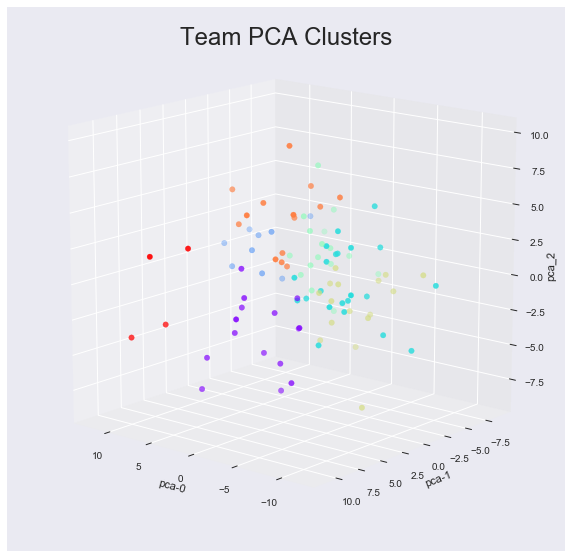

In [380]:
fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(pca_train_df.iloc[:,0], pca_train_df.iloc[:,1], pca_train_df.iloc[:,2], c=labels,cmap='rainbow', s=30)
plt.title('Team PCA Clusters',fontsize=24)
ax.set(xlabel='pca-0',ylabel="pca-1",zlabel="pca_2")
ax.view_init(15, 130)
plt.draw()

In [206]:
pca_train_df['labels'] = list(labels)

In [210]:
pca_train_df.groupby('labels')['W_standings_next'].describe()

,count,mean,std,min,25%,50%,75%,max
labels,,,,,,,,
0,41.0,6.804878,3.100157,2.0,4.0,7.0,9.00,13.0
1,24.0,9.125000,3.040488,2.0,8.0,9.0,11.25,15.0
2,31.0,8.645161,2.589059,4.0,7.0,8.0,11.00,12.0


In [244]:
from scipy.cluster.hierarchy import dendrogram, linkage, cophenet, fcluster
from scipy.spatial.distance import pdist

In [245]:
Z = linkage(pca_train_df.iloc[:,:3], 'single')
c, coph_dists = cophenet(Z, pdist(pca_train_df.iloc[:,:3]))
print c

Z = linkage(pca_train_df.iloc[:,:3], 'complete')
c, coph_dists = cophenet(Z, pdist(pca_train_df.iloc[:,:3]))
print c

Z = linkage(pca_train_df.iloc[:,:3], 'average')
c, coph_dists = cophenet(Z, pdist(pca_train_df.iloc[:,:3]))
print c

0.492540712176
0.487917719821
0.616930557682


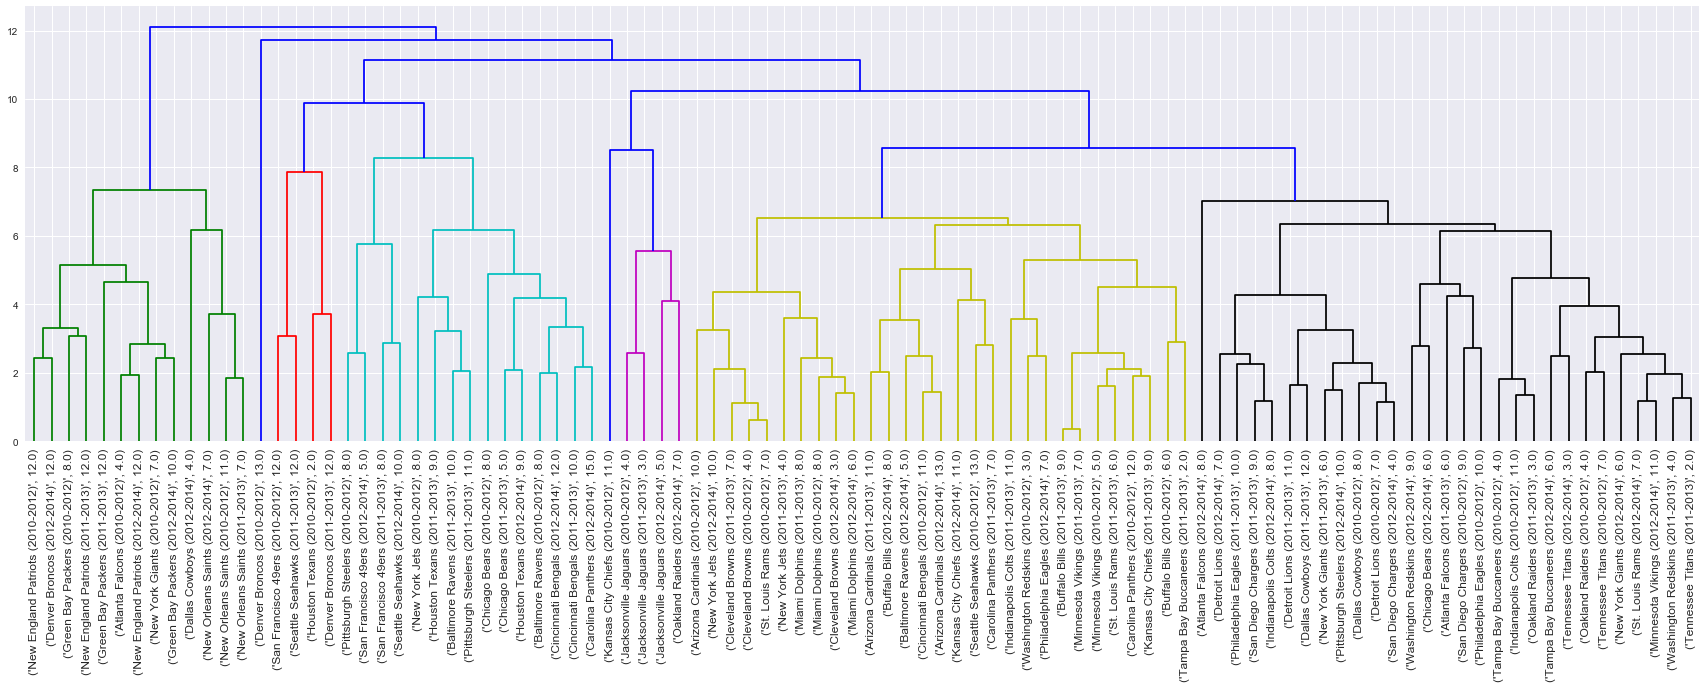

In [332]:
Z = linkage(pca_train_df.iloc[:,:3], 'average')
fig, ax = plt.subplots(figsize=(30,8))
dn = dendrogram(Z, orientation='top', labels=zip(pca_train_df.index,pca_train_df['W_standings_next']),leaf_font_size=12)
